# Demo Notebook for Leela Logit Lens

In [1]:
from leela_interp import Lc0sight, LeelaBoard

In [2]:
model = Lc0sight("../lc0-original.onnx")

Using device: cpu


In [3]:
from leela_logit_lens import LeelaLogitLens

In [4]:
lens = LeelaLogitLens(model)

Now sample some puzzles. Here we use the puzzles from Jenner et al. but expanded with the history. 

In [5]:
import pickle
# load the puzzles
with open("../data/interesting_puzzles_history.pkl", "rb") as f:
    puzzles = pickle.load(f)

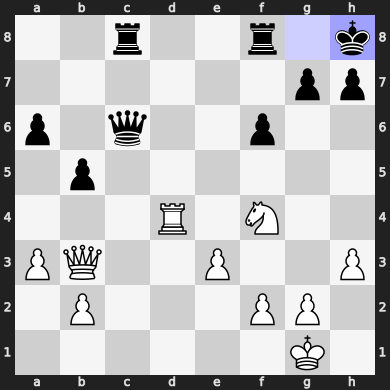

In [6]:
# Select a puzzle index to plot this is the puzzle from Jenner et al. 
puzzle_index = 483
puzzle = puzzles.iloc[puzzle_index]
board = LeelaBoard.from_pgn(puzzle['Puzzle_PGN'])
board

In [7]:
puzzle.principal_variation

['f4g6', 'h7g6', 'd4h4']

### Using the Leela Logit Lens on an example puzzle

In [8]:
# Choose a layer to project from
layer_idx = 10

In [9]:
result = lens(boards=board, layer_idx=layer_idx, return_probs=True, return_policy_as_dict=True)

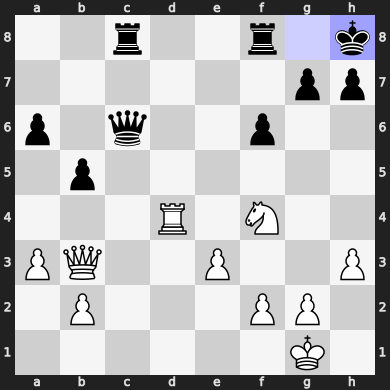

In [10]:
# Returns a list of results for each board in boards. If only one board is passed index with 0
result[0]['board']

In [11]:
# The complete policy tensor without masking (illegal moves have prob 0)
result[0]['policy'].shape

torch.Size([1858])

In [12]:
# Sorted intermediate policy
sorted(result[0]['policy_as_dict'].items(), key=lambda x: x[1], reverse=True)

[('b3e6', 0.19789938628673553),
 ('f4g6', 0.17794154584407806),
 ('f4e6', 0.11888451129198074),
 ('b3g8', 0.07244529575109482),
 ('d4d8', 0.06792008131742477),
 ('b3c2', 0.05125797539949417),
 ('f4d3', 0.04310540109872818),
 ('g1h2', 0.04267524182796478),
 ('b3d3', 0.03870167210698128),
 ('b3b5', 0.03742009028792381),
 ('b3d1', 0.03393946588039398),
 ('d4c4', 0.026541095227003098),
 ('b3f7', 0.015862813219428062),
 ('d4e4', 0.00846958253532648),
 ('b3d5', 0.008461404591798782),
 ('b3a4', 0.007247135043144226),
 ('b3c4', 0.006516420282423496),
 ('g1h1', 0.0062876297160983086),
 ('b3b4', 0.005524622276425362),
 ('g1f1', 0.004928680136799812),
 ('f4d5', 0.004043790977448225),
 ('f4e2', 0.003963392693549395),
 ('d4d7', 0.0034378902055323124),
 ('b3a2', 0.0028671619947999716),
 ('d4d1', 0.0018939960282295942),
 ('b3c3', 0.001754139200784266),
 ('e3e4', 0.0015918161952868104),
 ('d4d6', 0.0015383291756734252),
 ('d4d5', 0.0011452166363596916),
 ('d4d2', 0.001125530106946826),
 ('d4a4', 0.000

### Visualizing the intermediate policy

In [13]:
from leela_logit_lens.tools.plotting_helpers import make_translucent_arrows, PolicyBarWithColors
import iceberg as ice
from leela_interp.tools import figure_helpers as fh
from leela_logit_lens.tools.utils import get_top_k_moves
import chess

In [14]:
move_colors = [
   ice.Color.from_hex(fh.COLORS[2]),  # red
   ice.Color.from_hex(fh.COLORS[0]),  # green
   ice.Color.from_hex(fh.COLORS[1]),  # blue
]

In [15]:
###############################################################################
# A function to map layer_idx to a title string.
#    - 0 -> "Input Encoding"
#    - 1..14 -> "Layer 0..13" respectively
#    - 15 -> "Full Model"
# Needed because there are both an input encoding and a 0th layer
###############################################################################
def layer_title(layer_idx: int) -> str:
    if layer_idx == 0:
        return "Input Encoding"
    elif layer_idx == 15:
        return "Full Model"
    else:
        return f"Layer {layer_idx - 1}"

In [16]:
# --- 1. Setup: Extract data for the final layer ---
entry = result[0]
board = entry['board']
policy_dict = entry['policy_as_dict']

In [17]:
# --- 2. Create the Board Plot and Vertically Arrange with Title ---
arrows = make_translucent_arrows(
    policy_as_dict=policy_dict,
    k=3,
    colors=move_colors
)

# Create and scale the board plot
board_plot = board.plot(
    arrows=arrows,
    show_lastmove=False
)
board_plot = board_plot.crop(board_plot.bounds)

mapped_title = layer_title(layer_idx)

# Create the title text object
title = ice.Text(
    f"{mapped_title}",
    ice.FontStyle("Monaco", size=40),
).pad(10)

# Vertically combine the board and its title into a single object
board_with_title = board_plot + title.relative_to(
    board_plot, ice.BOTTOM_MIDDLE, ice.TOP_MIDDLE
)

In [18]:
# --- 3. Create the Policy Bar ---
top_moves = get_top_k_moves(policy_dict, k=3)
output_policy_dict_uci = dict(top_moves)
output_policy_dict_san = {
    board.pc_board.san(chess.Move.from_uci(move)): prob
    for move, prob in output_policy_dict_uci.items()
}

policy_bar = PolicyBarWithColors(
    numbers=list(output_policy_dict_san.values()),
    bar_labels=list(output_policy_dict_san.keys()),
    bar_colors=move_colors,
    label_font_family=fh.FONT_FAMILY,
    use_tex=True,
    # Using consistent styling from your reference code
    bar_height=60,
    move_scale=0.6,
    bar_width=25,
    label_font_size=18,
).scale(2)

In [19]:
# --- 4. Create the Brace ---
# The brace's width should match the height of the board *without* the title.
brace = ice.Brace(target_width=board_plot.bounds.height, target_height=30)
brace = ice.Transform(child=brace, rotation=-90).pad_left(20)

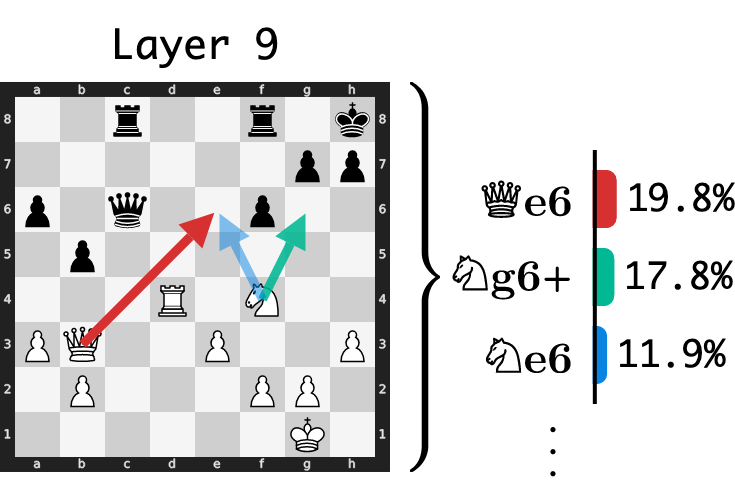

In [20]:
# --- 5. Correct the Final Arrangement in Two Steps ---
# Step A: Arrange the main components (board+title and policy bar).
# Increase the gap to make room for the brace.
main_arrangement = ice.Arrange(
    [
        board_with_title,
        policy_bar.pad_top(150)
    ],
    gap=60,
    arrange_direction=ice.HORIZONTAL
)

# Step B: Add the brace, positioning it relative to ONLY the board_plot.
final_plot = main_arrangement + brace.relative_to(
    board_plot, # Anchor the brace to the board, not the board+title
    ice.MIDDLE_LEFT, # Place the brace at the right edge of the board...
    ice.MIDDLE_RIGHT, # ...aligning the brace's left edge to it.
    # offset=(60, 0) # Add horizontal offset to center it in the gap
)

# Display the final composed plot
final_plot


### Use the lens for multiple layers at once

In [21]:
# Specify a list of layer indices to map from. If None are specified all are used
layer_indices = None

In [22]:
results = lens.multi_layer_lens(boards=board, layer_indices=layer_indices, return_probs=True, return_policy_as_dict=True)

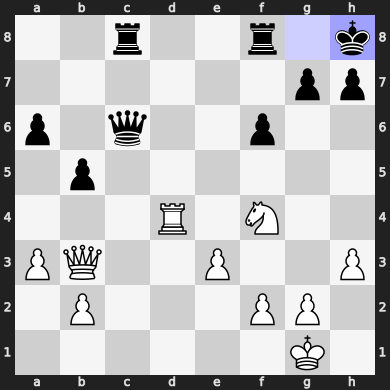

In [23]:
# The output is again a list. To access the first board index with 0
results[0]['board']

In [24]:
# Multi layer lens now returns a dict of layers where each entry is similar to the output of a single layer from above
type(results[0]['layers']), results[0]['layers'].keys()

(dict, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]))

In [25]:
results[0]['layers'][layer_idx]['policy'].shape

torch.Size([1858])

In [26]:
# Sorted intermediate policy with the index from above
sorted(results[0]['layers'][13]['policy_as_dict'].items(), key=lambda x: x[1], reverse=True)

[('f4g6', 0.603068470954895),
 ('b3d3', 0.09980438649654388),
 ('f4e6', 0.07889770716428757),
 ('g1h2', 0.03430493175983429),
 ('b3e6', 0.034009505063295364),
 ('f4d3', 0.03092925064265728),
 ('h3h4', 0.021137909963726997),
 ('b3d1', 0.011100390926003456),
 ('d4d8', 0.010638625361025333),
 ('g1f1', 0.009549188427627087),
 ('b3g8', 0.007174203172326088),
 ('d4e4', 0.006529585923999548),
 ('b3b5', 0.00578651437535882),
 ('b3b4', 0.005504241678863764),
 ('f4e2', 0.005361464805901051),
 ('d4d7', 0.0038338990416377783),
 ('b3a4', 0.003331983694806695),
 ('b3d5', 0.002986426232382655),
 ('b3f7', 0.0028286415617913008),
 ('g1h1', 0.0027154777199029922),
 ('b3c2', 0.001955609302967787),
 ('d4d5', 0.0019408625084906816),
 ('e3e4', 0.0018777052173390985),
 ('d4d1', 0.001692475751042366),
 ('b3c3', 0.0014574422966688871),
 ('d4a4', 0.0013202037662267685),
 ('d4c4', 0.0013067442923784256),
 ('d4d6', 0.0012602590722963214),
 ('b3c4', 0.0012514854315668344),
 ('f4d5', 0.0010153446346521378),
 ('d4d3

### Visualizing all intermediate policies

In [27]:
###############################################################################
# A small helper to chunk a list into sub-lists of size n
###############################################################################
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

In [28]:
###############################################################################
# A function to map layer_idx to a title string.
#    - 0 -> "Input Encoding"
#    - 1..14 -> "Layer 0..13" respectively
#    - 15 -> "Full Model"
# Needed because there are both an input encoding and a 0th layer
###############################################################################
def layer_title(layer_idx: int) -> str:
    if layer_idx == 0:
        return "Input Encoding"
    elif layer_idx == 15:
        return "Full Model"
    else:
        return f"Layer {layer_idx - 1}"

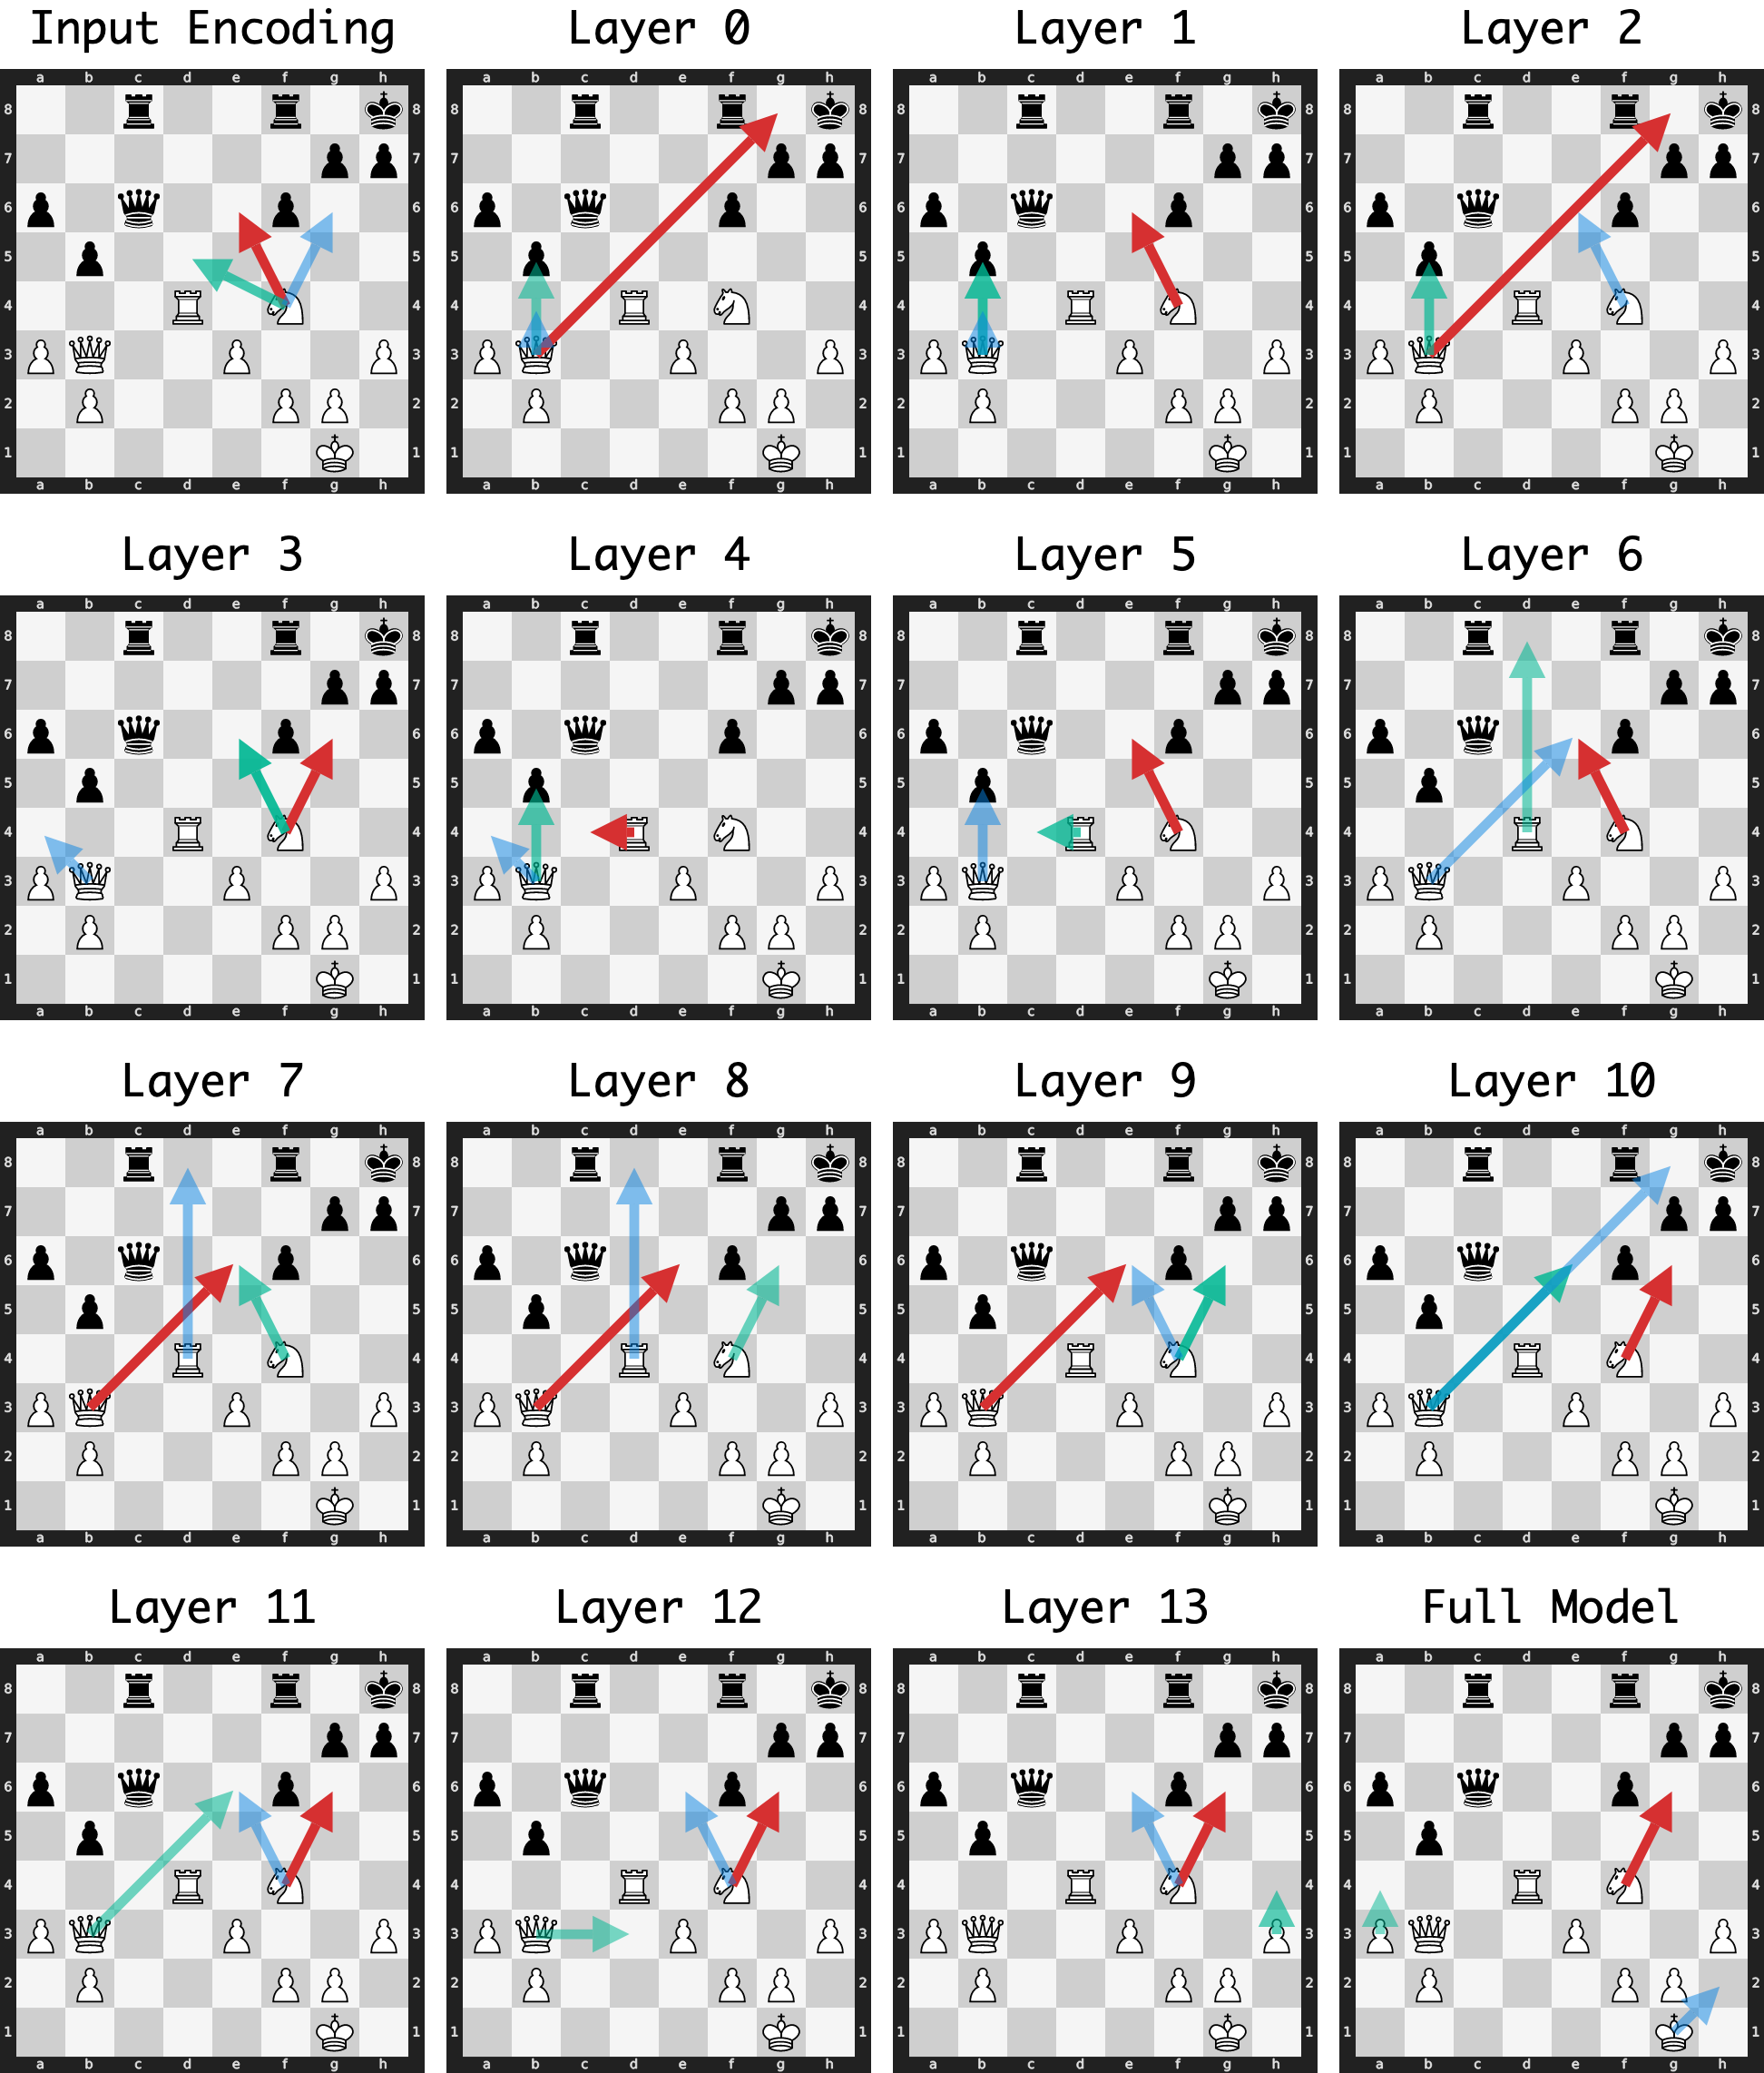

In [29]:
import iceberg as ice

layers = results[0]['layers']

layer_plots = []
for i in layers.keys():
    layer = layers[i]
    board_plot = layer['board'].plot(
        arrows=make_translucent_arrows(layer['policy_as_dict'], 
                                       k=3,
                                      colors=move_colors),
        show_lastmove=False
    )

    label = ice.Text(
    f"{layer_title(i)}",
    ice.FontStyle("Monaco", size=40),
).relative_to(board_plot, ice.UP * 10)
#    label = ice.Tex(tex=layer_title(i)).scale(3).relative_to(board_plot, ice.UP * 10)

    full_plot = (board_plot + label).crop((board_plot + label).bounds)

    layer_plots.append(full_plot)

# Arrange in 4×4 grid
rows = [
    ice.Arrange(layer_plots[i:i+4], arrange_direction=ice.Arrange.Direction.HORIZONTAL, gap=20)
    for i in range(0, 16, 4)
]

scene = ice.Arrange(rows, arrange_direction=ice.Arrange.Direction.VERTICAL, gap=30).scale(1.2)
scene

## Saving with Probability Tables

In [30]:
import chess
import numpy as np
from pathlib import Path

def create_split_probability_tables(results_dict):
    """
    Creates two split LaTeX probability tables with improved move ordering and labeling.
    - Moves are ordered by their peak probability across ALL layers.
    - Layer headers are formatted as "Layer X".
    - The table is split into two non-overlapping parts.
    """
    # --- 1. Extract and Validate Data ---
    if not results_dict or not isinstance(results_dict, list):
        return "% No valid data provided."

    board_result = results_dict[0]
    layers_data = board_result.get('layers', {})
    board = board_result.get('board')

    if not layers_data or not board:
        return "% Missing 'layers' or 'board' data in the dictionary."

    layer_indices = sorted(layers_data.keys())
    if not layer_indices:
        return "% No layer data found."
    
    # --- 2. Define Split Point ---
    split_index = len(layer_indices) // 2
    table1_indices = layer_indices[:split_index]
    table2_indices = layer_indices[split_index:] # Non-overlapping split

    # --- 3. Order Moves by Peak Probability Across ALL Layers ---
    try:
        all_legal_moves_uci = [move.uci() for move in board.pc_board.legal_moves]
    except AttributeError:
        return "% Board object is invalid."

    def get_max_prob_overall(move_uci):
        """Helper function to find the max probability of a move in any layer."""
        max_prob = 0
        # Iterate through ALL layer indices
        for layer_idx in layer_indices:
            prob = layers_data[layer_idx].get('policy_as_dict', {}).get(move_uci, 0.0)
            if prob > max_prob:
                max_prob = prob
        return max_prob

    # Sort moves based on the highest probability they reached in ANY layer
    sorted_moves_uci = sorted(
        all_legal_moves_uci,
        key=get_max_prob_overall,
        reverse=True
    )

    # --- 4. Helper Function to Generate Each Sub-Table ---
    def _generate_sub_table(table_layer_indices, caption_part):
        num_cols = len(table_layer_indices) + 1
        col_spec = 'l' + 'r' * (num_cols - 1)

        latex_string = f"""\\begin{{table*}}[h!]
\\centering
\\caption{{Layer-wise policy probability evolution ({caption_part})}}
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{{col_spec}}}
\\toprule
\\textbf{{Move}}"""

        # Add Header Row with new labeling
        final_layer_idx = max(layer_indices)
        for layer_idx in table_layer_indices:
            if layer_idx == 0:
                header = "Input"
            elif layer_idx == final_layer_idx:
                header = "Final"
            else:
                header = f"Layer {layer_idx - 1}" # Use "Layer X" format
            latex_string += f" & \\textbf{{{header}}}"
        latex_string += " \\\\\n\\midrule\n"

        # Add Data Rows
        for move_uci in sorted_moves_uci:
            move_san = board.pc_board.san(chess.Move.from_uci(move_uci))
            move_cell = f"\\wmove{{{move_san}}}"
            latex_string += move_cell
            
            for layer_idx in table_layer_indices:
                policy_dict = layers_data[layer_idx].get('policy_as_dict', {})
                prob = policy_dict.get(move_uci, 0.0) * 100
                latex_string += f" & {prob:.2f}\\%"
            latex_string += " \\\\\n"

        latex_string += """\\bottomrule
\\end{tabular}%
}
\\end{table*}"""
        return latex_string

    # --- 5. Generate and Return Both Tables ---
    caption1 = f"Part 1: Input to Layer {split_index - 2}"
    caption2 = f"Part 2: Layer {split_index - 1} to Final"
    
    latex_part1 = _generate_sub_table(table1_indices, caption1)
    latex_part2 = _generate_sub_table(table2_indices, caption2)

    return latex_part1 + "\n\n" + latex_part2

In [31]:
latex_table = create_split_probability_tables(results)

In [32]:
output_dir = Path("Figures/Puzzles")
output_dir.mkdir(parents=True, exist_ok=True)

In [33]:
tex_file_path = output_dir / f"puzzle_tables_{puzzle_index}.tex"

In [34]:
with open(tex_file_path, "w", encoding="utf-8") as f:
    f.write(latex_table)

In [35]:
image_file_path = output_dir / f"puzzle_visualization_{puzzle_index}.pdf"

In [36]:
scene.render(str(image_file_path))